# 数据准备

In [1]:
import datasets
from datasets import load_dataset

dataset = load_dataset('snli')
# filter_dataset = dataset.filter(lambda x: x['train']['label'] != -1)
len(dataset['train']), len(dataset['test']), len(dataset['validation'])

Reusing dataset snli (/root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

(550152, 10000, 10000)

In [2]:
# snli 数据集中含有标签为 -1 的数据, 需去除
dataset = dataset.filter(lambda x: x['label'] != -1)
print(len(dataset['train']), len(dataset['test']), len(dataset['validation']))

Loading cached processed dataset at /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-a456b5c8e4a9be8b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-23b15657e1b03e29.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-107582d3946c7465.arrow


549367 9824 9842


In [3]:
# 查看数据
dataset['train'][0]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1}

# 训练词向量

In [3]:
import re
from d2l import torch as d2l
from gensim.models import word2vec

In [8]:
# 预处理训练数据集中的所有前提和假设文本，用于训练词向量
def process(sentence):
    sentence = re.sub(r'[^0-9a-zA-Z]', ' ', sentence)
    sentence = re.sub('\\s{2,}', ' ', sentence)
    return sentence

premise = [process(sen) for sen in dataset['train']['premise']]
hypothesis = [process(sen) for sen in dataset['train']['hypothesis']]

# d2l.tokenize 函数将文本行拆分为单词列表
all_word_tokens = d2l.tokenize(premise + hypothesis)
print("前提和假设, 一共有 %d 条文本" %len(all_word_tokens))

前提和假设, 一共有 1098734 条文本


In [10]:
# 训练词向量, 保存模型
file_path = '/root/autodl-tmp/fam_classifier/snli/'
model = word2vec.Word2Vec(sentences=all_word_tokens, vector_size=512, sg=1, min_count=5)
print(f'词向量模型中保存的单词数量为 {len(model.wv.index_to_key)}')
model.save(file_path + "snli_word_vec_sg.bin")

# 因子分析

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# from gensim.models import word2vec
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

In [12]:
# 加载 word2vector 模型
model = word2vec.Word2Vec.load(file_path + 'snli_word_vec_sg.bin')

In [13]:
embedding = np.array([model.wv[word] for word in model.wv.index_to_key])
print(f"词向量矩阵尺寸: {embedding.shape}")
# 查看某个单词的词向量
print("单词film: ", model.wv.key_to_index['film'], model.wv['film'])

词向量矩阵尺寸: (18013, 512)
单词film:  2799 [-0.00724013 -0.10913222  0.04341228  0.11346389  0.16254008  0.0366252
 -0.44656247 -0.39848262  0.21697992  0.18219218  0.11924364 -0.32960695
  0.04791654 -0.18406308  0.1931095   0.3777498  -0.3930081  -0.3743648
  0.19197209  0.03161134  0.1955071   0.02634477 -0.1414992  -0.06041318
  0.08276789 -0.01444112 -0.07045831 -0.04761468 -0.08272061  0.17852792
  0.14226787 -0.07250947  0.07479661 -0.03815974 -0.08395808  0.16449836
 -0.01970773  0.2817188   0.03026474 -0.04028096  0.12275925 -0.05409699
  0.12422354  0.02302836  0.07309227 -0.08715077  0.1813989  -0.0318147
  0.03556602  0.00153483 -0.1545816   0.07308168 -0.16077708  0.10873608
 -0.0785303  -0.13141859 -0.12233703 -0.15875275 -0.14376798 -0.05250243
  0.03379635 -0.06930894 -0.12644704 -0.05671006  0.04789349 -0.05730378
  0.14501455  0.08123948 -0.1319076  -0.05425244  0.15634419  0.00714099
  0.19172099  0.05201561 -0.30197665  0.05441812 -0.07388601 -0.14998175
 -0.21916898 -0.12

In [14]:
# Bartlett's球状检验
print('Bartlett\'s球状检验: 检验总体变量的相关矩阵是否是单位阵')
chi_square_value, p_value = calculate_bartlett_sphericity(embedding)
print(chi_square_value, p_value)

# 导入kmo检验
print('kmo检验:')
print('检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好')
kmo_all, kmo_model = calculate_kmo(embedding)
print('KMO值为: ', kmo_model)

Bartlett's球状检验: 检验总体变量的相关矩阵是否是单位阵
8436164.25914173 0.0
kmo检验:
检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好
KMO值为:  0.3837290706272836


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [15]:
print('******开始因子分析******')
fa = FactorAnalyzer(25, rotation='varimax')
fa.fit(embedding)

# 特征值、特征向量
ev, v = fa.get_eigenvalues()

******开始因子分析******


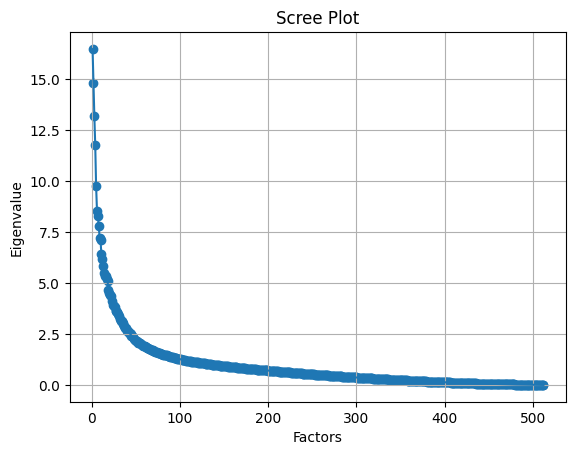

In [16]:
# 可视化, plot横轴是指标个数，纵轴是ev值
plt.scatter(range(1, embedding.shape[1]+1), ev)
plt.plot(range(1, embedding.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
# plt.savefig('ev.png')

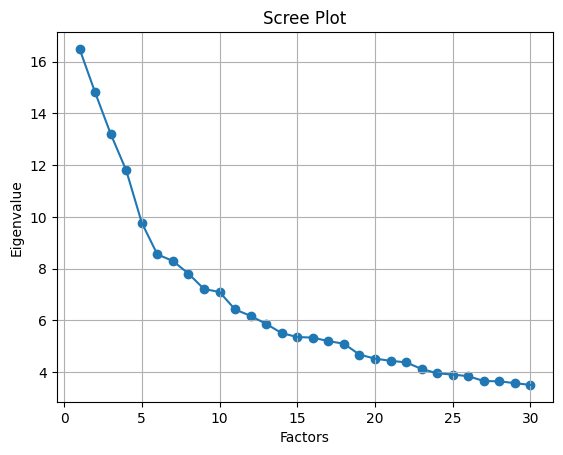

In [17]:
# 前三十
plt.scatter(range(1, 31), ev[:30])
plt.plot(range(1, 31), ev[:30])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
# plt.savefig(file_path + 'ev30.png')

In [18]:
# 8 个因子头的因子分析
fa = FactorAnalyzer(8, rotation="promax")
fa.fit(embedding)
print(fa.loadings_.shape)
# 512*8 (变量个数*因子个数)
index = fa.loadings_.argmax(axis=1)
res = np.array([[i, idx] for i, idx in enumerate(index)])

data_1 = pd.DataFrame(fa.loadings_, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])
data_2 = pd.DataFrame(res, columns=['Dimension', 'Factor'])
with pd.ExcelWriter(file_path + "snliFA.xlsx") as writer1:
    data_1.to_excel(writer1, sheet_name="Sheet1")
    data_2.to_excel(writer1, sheet_name="Sheet2")
    writer1.save()

(512, 8)


Text(120.72222222222221, 0.5, 'Dimension')

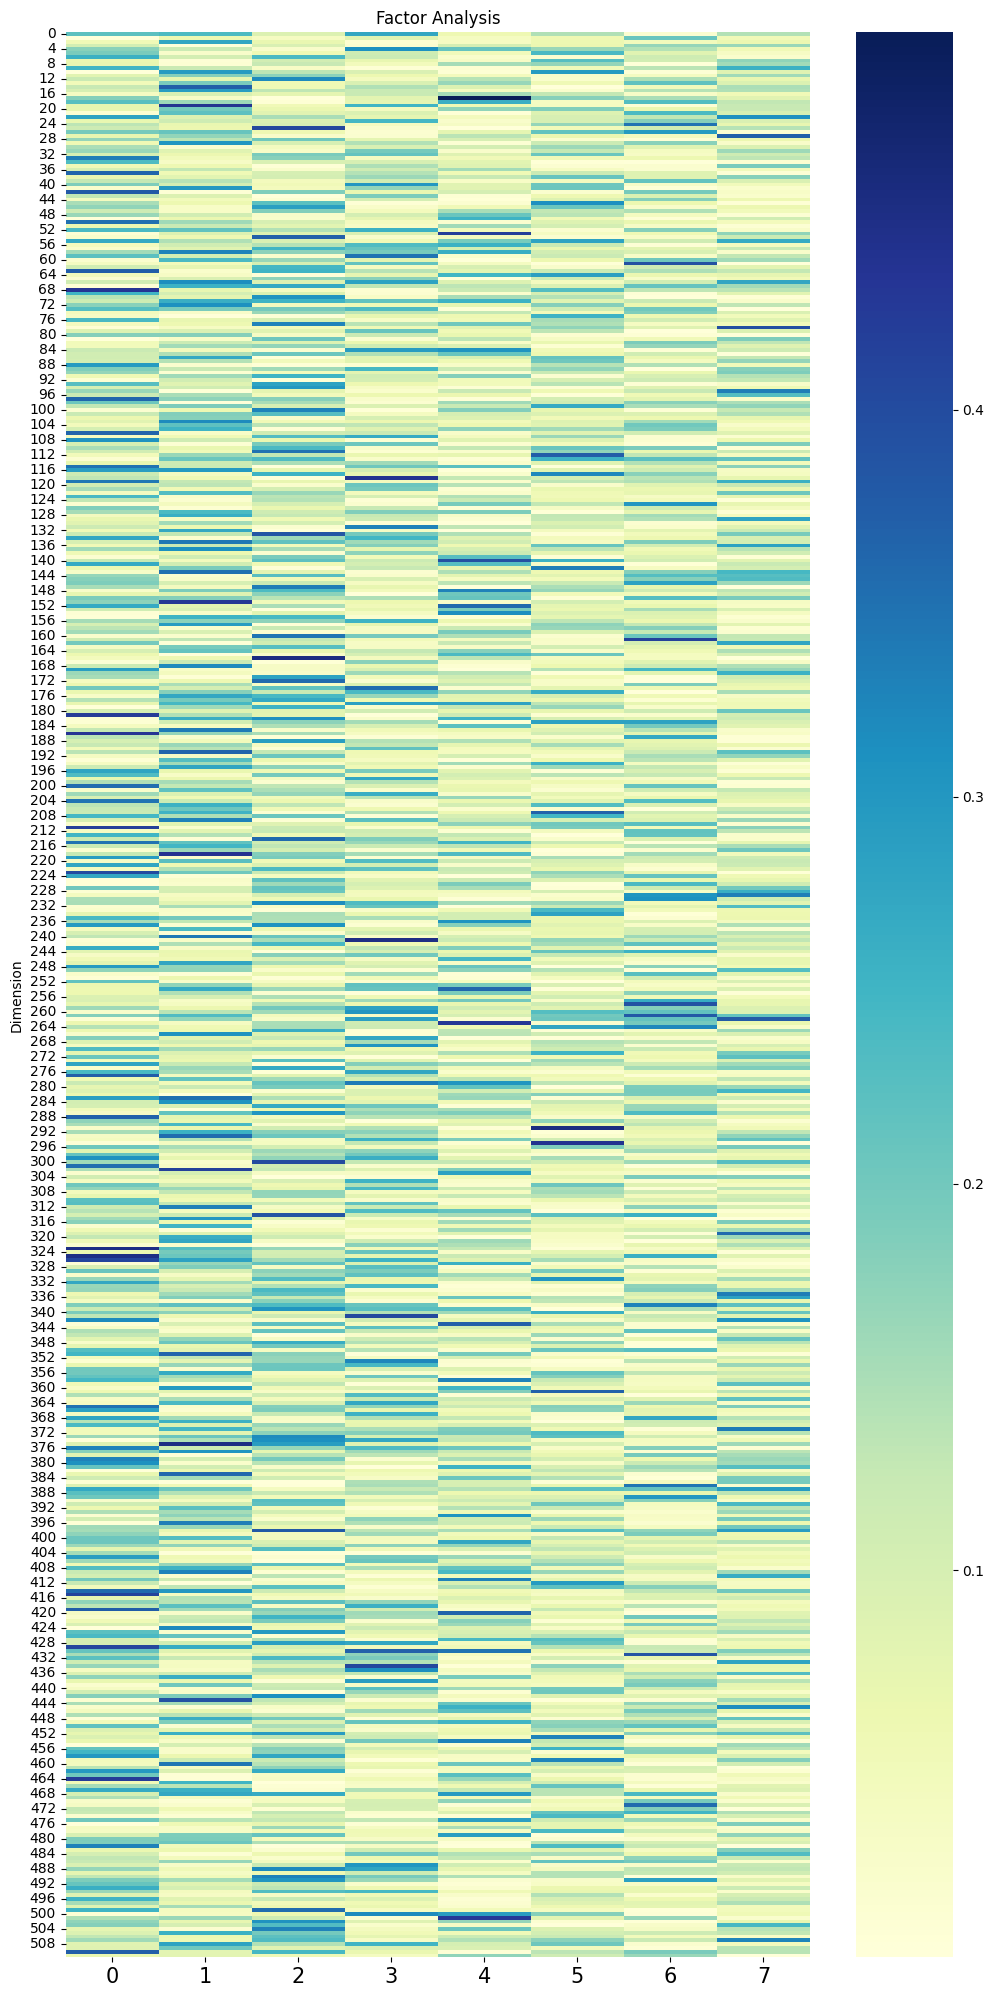

In [19]:
# 因子分析结果可视化
df_cm = pd.DataFrame(np.abs(fa.loadings_))
fig, ax = plt.subplots(figsize=(12, 25))
sns.heatmap(df_cm, annot=None, cmap='YlGnBu', ax=ax)  # cbar_kws

ax.tick_params(axis='x', labelsize=15)
ax.set_title("Factor Analysis", fontsize=12)
ax.set_ylabel("Dimension")

In [20]:
# 保存可视化结果图
plt.savefig(file_path + 'snli_dimension.png')

<Figure size 640x480 with 0 Axes>

# 模型架构

In [4]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import time
import math
from collections import Counter
# import re
# from gensim.models import word2vec

## FAM

In [5]:
class FamAttention(nn.Module):
    """修改多头注意力，针对嵌入512维，8个head的模型"""
    def __init__(self, num_hiddens, dim_dict, dropout, bias=False, **kwargs):
        super(FamAttention, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dim_dict = dim_dict
        self.dim_0 = [dim for dim, idx in self.dim_dict.items() if idx == 0]
        self.dim_1 = [dim for dim, idx in self.dim_dict.items() if idx == 1]
        self.dim_2 = [dim for dim, idx in self.dim_dict.items() if idx == 2]
        self.dim_3 = [dim for dim, idx in self.dim_dict.items() if idx == 3]
        self.dim_4 = [dim for dim, idx in self.dim_dict.items() if idx == 4]
        self.dim_5 = [dim for dim, idx in self.dim_dict.items() if idx == 5]
        self.dim_6 = [dim for dim, idx in self.dim_dict.items() if idx == 6]
        self.dim_7 = [dim for dim, idx in self.dim_dict.items() if idx == 7]
        # self.list_concat = torch.cat((self.dim_0, self.dim_1, self.dim_2, self.dim_3, self.dim_4, self.dim_5,
        # self.dim_6, self.dim_7))
        self.len_0, self.len_1, self.len_2, self.len_3, self.len_4, self.len_5, self.len_6, self.len_7 = len(
            self.dim_0), len(self.dim_1), len(self.dim_2), len(self.dim_3), len(self.dim_4), len(self.dim_5),\
            len(self.dim_6), len(self.dim_7)

        self.Wq0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wq1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wq2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wq3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wq4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wq5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wq6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wq7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wk0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wk1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wk2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wk3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wk4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wk5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wk6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wk7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wv0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wv1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wv2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wv3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wv4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wv5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wv6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wv7 = nn.Linear(self.len_7, self.len_7, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        def assemble(output_concat, list_concat):
            reslist = []
            for i in range(512):
                reslist.append(list_concat.index(i))
            return torch.index_select(output_concat, -1, torch.tensor(reslist, device=output_concat.device))

        # queries, keys, values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # qi, ki, vi的形状：(batch_size, 查询或者“键－值”对的个数， self.len_i)
        q0, k0, v0 = torch.index_select(queries, -1, torch.tensor(self.dim_0, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_0, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_0, device=values.device))
        q1, k1, v1 = torch.index_select(queries, -1, torch.tensor(self.dim_1, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_1, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_1, device=values.device))
        q2, k2, v2 = torch.index_select(queries, -1, torch.tensor(self.dim_2, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_2, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_2, device=values.device))
        q3, k3, v3 = torch.index_select(queries, -1, torch.tensor(self.dim_3, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_3, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_3, device=values.device))
        q4, k4, v4 = torch.index_select(queries, -1, torch.tensor(self.dim_4, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_4, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_4, device=values.device))
        q5, k5, v5 = torch.index_select(queries, -1, torch.tensor(self.dim_5, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_5, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_5, device=values.device))
        q6, k6, v6 = torch.index_select(queries, -1, torch.tensor(self.dim_6, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_6, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_6, device=values.device))
        q7, k7, v7 = torch.index_select(queries, -1, torch.tensor(self.dim_7, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_7, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_7, device=values.device))

        head0 = self.attention(self.Wq0(q0), self.Wk0(k0), self.Wv0(v0), valid_lens)
        head1 = self.attention(self.Wq1(q1), self.Wk1(k1), self.Wv1(v1), valid_lens)
        head2 = self.attention(self.Wq2(q2), self.Wk2(k2), self.Wv2(v2), valid_lens)
        head3 = self.attention(self.Wq3(q3), self.Wk3(k3), self.Wv3(v3), valid_lens)
        head4 = self.attention(self.Wq4(q4), self.Wk4(k4), self.Wv4(v4), valid_lens)
        head5 = self.attention(self.Wq5(q5), self.Wk5(k5), self.Wv5(v5), valid_lens)
        head6 = self.attention(self.Wq6(q6), self.Wk6(k6), self.Wv6(v6), valid_lens)
        head7 = self.attention(self.Wq7(q7), self.Wk7(k7), self.Wv7(v7), valid_lens)

        output_concat = torch.cat((head0, head1, head2, head3, head4, head5, head6, head7), dim=-1)
        list_concat = self.dim_0 + self.dim_1 + self.dim_2 + self.dim_3 + self.dim_4 + self.dim_5 + self.dim_6 + self.dim_7
        return self.W_o(assemble(output_concat, list_concat))

In [6]:
# 编码器块
class EncoderBlock(nn.Module):
    """transformer编码器块"""

    def __init__(self, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = FamAttention(num_hiddens, dim_dict, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [7]:
class FamEncoder(nn.Module):
    """采用BERT编码器结构"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout, max_len=128,
                 **kwargs):
        super(FamEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        self.agg_layer = nn.Sequential(nn.Linear(num_hiddens, num_hiddens),
                                      nn.ReLU())
        self.output = nn.Linear(num_hiddens, 3)
        for i in range(num_layers):
            self.blks.add_module(f"{i}", EncoderBlock(
                num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, dim_dict, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        # 取句首'<cls>'标签对应的输出向量用于分类
        return self.output(self.agg_layer(X[:, 0, :]))

## Baseline

In [5]:
# 常规编码器
class BaseEncoder(nn.Module):
    """采用BERT编码器结构"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=128, key_size=512, query_size=512, value_size=512,
                 **kwargs):
        super(BaseEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        self.agg_layer = nn.Sequential(nn.Linear(num_hiddens, num_hiddens),
                                      nn.ReLU())
        self.output = nn.Linear(num_hiddens, 3)
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        # 取句首'<cls>'标签对应的输出向量用于分类
        return self.output(self.agg_layer(X[:, 0, :]))

# 训练和测试数据集

In [6]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        premise = [self._process(sen) for sen in dataset['premise']]
        hypothesis = [self._process(sen) for sen in dataset['hypothesis']]
        # all_premise_hypothesis_tokens = [d2l.tokenize(sentences)
        #     for sentences in [premise, hypothesis]]
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize(sentences)
              for sentences in [premise, hypothesis]])]
        self.labels = torch.tensor(dataset['label'])
        if vocab is None:
            self.vocab = d2l.Vocab(d2l.tokenize(premise + hypothesis), min_freq=5,
                                   reserved_tokens=['<pad>', '<cls>', '<pad>', '<sep>'])
        else:
            self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _process(self, raw_sentences):
        raw_sentences = re.sub(r'[^0-9a-zA-Z]', ' ', raw_sentences)
        raw_sentences = re.sub('\\s{2,}', ' ', raw_sentences)
        return raw_sentences

    def _preprocess(self, all_premise_hypothesis_tokens):
        # pool = multiprocessing.Pool(4)  # 使用4个进程
        # out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        out = list(map(self._mp_worker, all_premise_hypothesis_tokens))
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [7]:
batch_size, max_len = 512, 128
train_set = SNLIBERTDataset(dataset['train'], max_len)
vocab = train_set.vocab
print(f"训练集词表大小: {len(vocab)}")
test_set = SNLIBERTDataset(dataset['test'], max_len, vocab)
validation_set = SNLIBERTDataset(dataset['validation'], max_len, vocab)

read 549367 examples
训练集词表大小: 18018
read 9824 examples
read 9842 examples


In [8]:
# 查看标签数量统计
# from collections import Counter
cnt = Counter(train_set.labels.numpy())
cnt

Counter({1: 182764, 2: 183187, 0: 183416})

In [11]:
# 检测数据集中有无 -1 标签
for data in dataset['train']:
    if data['label'] == -1:
        print(data)
        break

In [17]:
# 生成可迭代数据集
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)
validation_iter = torch.utils.data.DataLoader(validation_set, batch_size, shuffle=False)
print(f'训练集大小: {len(train_iter)}, 测试集大小: {len(test_iter)}, 验证集大小: {len(validation_iter)}')

训练集大小: 1073, 测试集大小: 20, 验证集大小: 20


# 训练准备

## 参数和超参数, 实例化模型

In [9]:
# 参数和超参数
num_hiddens, num_layers, dropout = 512, 3, 0.1
ffn_num_input, ffn_num_hiddens, num_heads, norm_shape = 512, 2048, 8, [512]
lr, num_epochs, device = 5e-5, 30, d2l.try_gpu()

### FAM

In [16]:
file_path = '/root/autodl-tmp/fam_classifier/snli/'
excelfile = pd.read_excel(file_path + 'snliFA.xlsx', sheet_name='Sheet2', header=0, index_col=0)
dim_dict = dict()
for i in range(512):
    dim_dict[excelfile['Dimension'].values[i]] = excelfile['Factor'].values[i]

In [17]:
# 实例化 FAM 模型
net = FamEncoder(
    len(vocab), num_hiddens, norm_shape, ffn_num_input,
    ffn_num_hiddens, dim_dict, num_layers, dropout)
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

16,956,461 total parameters.
16,956,461 training parameters.


### Baseline

In [18]:
# 实例化 Baseline 模型
num_heads = 8
basenet = BaseEncoder(
    len(vocab), num_hiddens, norm_shape, ffn_num_input,
    ffn_num_hiddens, num_heads, num_layers, dropout)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in basenet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in basenet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

19,013,123 total parameters.
19,013,123 training parameters.


## 初始化模型参数

In [12]:
# 初始化embedding层模型权重
def get_embedding_weights(vocab, word2vecmodel, num_hiddens):
    wordlist = word2vecmodel.wv.index_to_key
    n = len(vocab)
    data = np.random.randn(n, num_hiddens)
    for i in range(n):
        word = vocab.idx_to_token[i]
        data[i] = np.array(word2vecmodel.wv[word]) if word in wordlist else data[i]
    return torch.tensor(data, dtype=torch.float32)


def init_embedding_weights(module, weights):
    module.weight.data = weights


# 初始化线性层权重
def xavier_init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


file_path = '/root/autodl-tmp/fam_classifier/snli/'
word2vecmodel = word2vec.Word2Vec.load(file_path + 'snli_word_vec_sg.bin')
weights = get_embedding_weights(vocab, word2vecmodel, num_hiddens)

### FAM

In [19]:
init_embedding_weights(net.token_embedding, weights)
net.apply(xavier_init_weights)

FamEncoder(
  (token_embedding): Embedding(18018, 512)
  (segment_embedding): Embedding(2, 512)
  (blks): Sequential(
    (0): EncoderBlock(
      (attention): FamAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_o): Linear(in_features=512, out_features=512, bias=True)
        (Wq0): Linear(in_features=77, out_features=77, bias=True)
        (Wq1): Linear(in_features=63, out_features=63, bias=True)
        (Wq2): Linear(in_features=81, out_features=81, bias=True)
        (Wq3): Linear(in_features=65, out_features=65, bias=True)
        (Wq4): Linear(in_features=54, out_features=54, bias=True)
        (Wq5): Linear(in_features=56, out_features=56, bias=True)
        (Wq6): Linear(in_features=67, out_features=67, bias=True)
        (Wq7): Linear(in_features=49, out_features=49, bias=True)
        (Wk0): Linear(in_features=77, out_features=77, bias=True)
        (Wk1): Linear(in_features=63, out_features=63, bias=T

In [20]:
# 查看模型参数
for name, parameters in net.named_parameters():
    print(name, ';', parameters.size())

pos_embedding ; torch.Size([1, 128, 512])
token_embedding.weight ; torch.Size([18018, 512])
segment_embedding.weight ; torch.Size([2, 512])
blks.0.attention.W_o.weight ; torch.Size([512, 512])
blks.0.attention.W_o.bias ; torch.Size([512])
blks.0.attention.Wq0.weight ; torch.Size([77, 77])
blks.0.attention.Wq0.bias ; torch.Size([77])
blks.0.attention.Wq1.weight ; torch.Size([63, 63])
blks.0.attention.Wq1.bias ; torch.Size([63])
blks.0.attention.Wq2.weight ; torch.Size([81, 81])
blks.0.attention.Wq2.bias ; torch.Size([81])
blks.0.attention.Wq3.weight ; torch.Size([65, 65])
blks.0.attention.Wq3.bias ; torch.Size([65])
blks.0.attention.Wq4.weight ; torch.Size([54, 54])
blks.0.attention.Wq4.bias ; torch.Size([54])
blks.0.attention.Wq5.weight ; torch.Size([56, 56])
blks.0.attention.Wq5.bias ; torch.Size([56])
blks.0.attention.Wq6.weight ; torch.Size([67, 67])
blks.0.attention.Wq6.bias ; torch.Size([67])
blks.0.attention.Wq7.weight ; torch.Size([49, 49])
blks.0.attention.Wq7.bias ; torch.Size

### Baseline

In [19]:
init_embedding_weights(basenet.token_embedding, weights)
basenet.apply(xavier_init_weights)

BaseEncoder(
  (token_embedding): Embedding(18018, 512)
  (segment_embedding): Embedding(2, 512)
  (blks): Sequential(
    (0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=512, out_features=2048, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (addnorm2): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
   

In [20]:
# 查看模型参数
for name, parameters in basenet.named_parameters():
    print(name, ';', parameters.size())

pos_embedding ; torch.Size([1, 128, 512])
token_embedding.weight ; torch.Size([18018, 512])
segment_embedding.weight ; torch.Size([2, 512])
blks.0.attention.W_q.weight ; torch.Size([512, 512])
blks.0.attention.W_q.bias ; torch.Size([512])
blks.0.attention.W_k.weight ; torch.Size([512, 512])
blks.0.attention.W_k.bias ; torch.Size([512])
blks.0.attention.W_v.weight ; torch.Size([512, 512])
blks.0.attention.W_v.bias ; torch.Size([512])
blks.0.attention.W_o.weight ; torch.Size([512, 512])
blks.0.attention.W_o.bias ; torch.Size([512])
blks.0.addnorm1.ln.weight ; torch.Size([512])
blks.0.addnorm1.ln.bias ; torch.Size([512])
blks.0.ffn.dense1.weight ; torch.Size([2048, 512])
blks.0.ffn.dense1.bias ; torch.Size([2048])
blks.0.ffn.dense2.weight ; torch.Size([512, 2048])
blks.0.ffn.dense2.bias ; torch.Size([512])
blks.0.addnorm2.ln.weight ; torch.Size([512])
blks.0.addnorm2.ln.bias ; torch.Size([512])
blks.1.attention.W_q.weight ; torch.Size([512, 512])
blks.1.attention.W_q.bias ; torch.Size([51

## 评估指标

In [36]:
# 测试 argmax() 函数
a = torch.tensor([[0.2, -0.6, 0.5],
                  [0.1, 0.7, 0.01]])
a.argmax(dim=-1), a.argmax()

(tensor([2, 1]), tensor(4))

In [15]:
# 定义评估模型准确率和F1指标的函数
from sklearn.metrics import accuracy_score, f1_score
# f1_score(labels, predicitons, average='None, 'micro', 'macro', 'weighted', 'samples)
def evaluate_accuracy_f1(net, data_iter, device=None):
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device

    y_pred, y_true = torch.tensor([], device=device), torch.tensor([], device=device)
    with torch.no_grad():
        for data in data_iter:
            X, y = data
            tokens, segments, valid_len = [x.to(device) for x in X]
            y = y.to(device)
            y_pred = torch.cat([y_pred, net(tokens, segments, valid_len).argmax(dim=-1)])
            y_true = torch.cat([y_true, y])
    return accuracy_score(y_pred.cpu(), y_true.cpu()), f1_score(y_pred.cpu(), y_true.cpu(), average='macro')

In [45]:
evaluate_accuracy_f1(net, test_iter)

(0.32949918566775244, 0.21441868725279453)

# 正式训练

## 2层 FAM , 30 epochs

In [46]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 14,489,631 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in net.named_parameters()
    if name != "token_embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.token_embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, segments, valid_len), y = data
        tokens, segments, valid_len = [v.to(device) for v in (tokens, segments, valid_len)]
        y = y.to(device)
        l = loss(net(tokens, segments, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{train_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 1073/1073 [03:07<00:00,  5.71it/s]


epoch 1, loss 1.041, train_acc 0.567, train_f1 0.566, test_acc 0.570, test_f1 0.569, taking 260 seconds


100%|██████████| 1073/1073 [03:07<00:00,  5.71it/s]


epoch 2, loss 0.893, train_acc 0.615, train_f1 0.612, test_acc 0.619, test_f1 0.615, taking 259 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.70it/s]


epoch 3, loss 0.844, train_acc 0.631, train_f1 0.627, test_acc 0.631, test_f1 0.626, taking 260 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.71it/s]


epoch 4, loss 0.814, train_acc 0.653, train_f1 0.653, test_acc 0.648, test_f1 0.648, taking 259 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.70it/s]


epoch 5, loss 0.788, train_acc 0.672, train_f1 0.672, test_acc 0.663, test_f1 0.662, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.71it/s]


epoch 6, loss 0.768, train_acc 0.678, train_f1 0.678, test_acc 0.667, test_f1 0.667, taking 260 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 7, loss 0.751, train_acc 0.686, train_f1 0.686, test_acc 0.676, test_f1 0.675, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.70it/s]


epoch 8, loss 0.737, train_acc 0.689, train_f1 0.686, test_acc 0.687, test_f1 0.682, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.70it/s]


epoch 9, loss 0.726, train_acc 0.698, train_f1 0.695, test_acc 0.688, test_f1 0.684, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 10, loss 0.715, train_acc 0.708, train_f1 0.707, test_acc 0.698, test_f1 0.697, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 11, loss 0.702, train_acc 0.717, train_f1 0.716, test_acc 0.701, test_f1 0.700, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 12, loss 0.691, train_acc 0.721, train_f1 0.718, test_acc 0.705, test_f1 0.701, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 13, loss 0.681, train_acc 0.729, train_f1 0.728, test_acc 0.712, test_f1 0.710, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 14, loss 0.669, train_acc 0.738, train_f1 0.737, test_acc 0.719, test_f1 0.717, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 15, loss 0.656, train_acc 0.745, train_f1 0.745, test_acc 0.723, test_f1 0.722, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 16, loss 0.645, train_acc 0.745, train_f1 0.743, test_acc 0.723, test_f1 0.722, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 17, loss 0.634, train_acc 0.755, train_f1 0.754, test_acc 0.728, test_f1 0.727, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 18, loss 0.625, train_acc 0.757, train_f1 0.757, test_acc 0.728, test_f1 0.728, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 19, loss 0.616, train_acc 0.758, train_f1 0.758, test_acc 0.731, test_f1 0.731, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 20, loss 0.608, train_acc 0.770, train_f1 0.769, test_acc 0.738, test_f1 0.737, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 21, loss 0.601, train_acc 0.773, train_f1 0.772, test_acc 0.739, test_f1 0.739, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 22, loss 0.593, train_acc 0.770, train_f1 0.768, test_acc 0.742, test_f1 0.739, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.70it/s]


epoch 23, loss 0.584, train_acc 0.777, train_f1 0.774, test_acc 0.737, test_f1 0.735, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 24, loss 0.576, train_acc 0.786, train_f1 0.786, test_acc 0.744, test_f1 0.743, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 25, loss 0.570, train_acc 0.786, train_f1 0.784, test_acc 0.742, test_f1 0.739, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 26, loss 0.563, train_acc 0.792, train_f1 0.791, test_acc 0.742, test_f1 0.742, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 27, loss 0.556, train_acc 0.795, train_f1 0.794, test_acc 0.749, test_f1 0.747, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 28, loss 0.549, train_acc 0.799, train_f1 0.799, test_acc 0.748, test_f1 0.748, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.69it/s]


epoch 29, loss 0.543, train_acc 0.802, train_f1 0.801, test_acc 0.748, test_f1 0.748, taking 261 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.70it/s]


epoch 30, loss 0.536, train_acc 0.802, train_f1 0.802, test_acc 0.742, test_f1 0.742, taking 261 seconds
Training is finished.
训练损失:0.536, 训练集准确率:0.802, 训练集f1:0.802, 测试集准确率:0.742, 测试集f1:0.802, 在设备cuda:0上训练30周期, 耗时7822 s


## 保存结果

In [47]:
print(f"训练集最佳准确率: {max(train_accuracy):.3f},\n"
    f"训练集最佳F1分数: {max(train_f1):.3f},\n"
    f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

训练集最佳准确率: 0.802,
训练集最佳F1分数: 0.802,
测试集最佳准确率: 0.749,
测试集最佳F1分数: 0.748


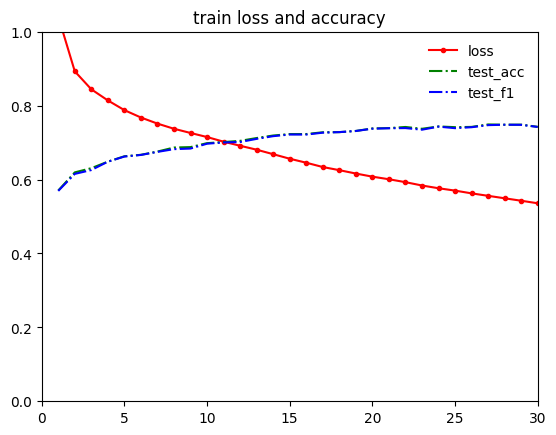

In [48]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [50]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/2layerfa.xlsx')

In [51]:
torch.save(net.state_dict(), file_path + 'output/2layer_state_dict.pth')

## 2 层 Baseline, 30 epochs

In [ ]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 15,860,739 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in basenet.named_parameters()
    if name != "token_embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': basenet.token_embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
basenet.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    basenet.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, segments, valid_len), y = data
        tokens, segments, valid_len = [v.to(device) for v in (tokens, segments, valid_len)]
        y = y.to(device)
        l = loss(basenet(tokens, segments, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(basenet, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(basenet, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{train_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 1073/1073 [02:12<00:00,  8.09it/s]


epoch 1, loss 1.065, train_acc 0.505, train_f1 0.505, test_acc 0.513, test_f1 0.513, taking 177 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.94it/s]


epoch 2, loss 0.950, train_acc 0.593, train_f1 0.591, test_acc 0.601, test_f1 0.599, taking 180 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.95it/s]


epoch 3, loss 0.886, train_acc 0.612, train_f1 0.607, test_acc 0.615, test_f1 0.608, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  7.98it/s]


epoch 4, loss 0.859, train_acc 0.622, train_f1 0.622, test_acc 0.626, test_f1 0.625, taking 179 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.94it/s]


epoch 5, loss 0.850, train_acc 0.625, train_f1 0.624, test_acc 0.625, test_f1 0.623, taking 180 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.93it/s]


epoch 6, loss 0.846, train_acc 0.621, train_f1 0.618, test_acc 0.627, test_f1 0.624, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  7.99it/s]


epoch 7, loss 0.849, train_acc 0.612, train_f1 0.609, test_acc 0.622, test_f1 0.620, taking 179 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.92it/s]


epoch 8, loss 0.849, train_acc 0.630, train_f1 0.630, test_acc 0.637, test_f1 0.636, taking 180 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.91it/s]


epoch 9, loss 0.846, train_acc 0.626, train_f1 0.625, test_acc 0.629, test_f1 0.627, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  7.95it/s]


epoch 10, loss 0.838, train_acc 0.629, train_f1 0.629, test_acc 0.633, test_f1 0.633, taking 180 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.95it/s]


epoch 11, loss 0.837, train_acc 0.628, train_f1 0.624, test_acc 0.628, test_f1 0.624, taking 180 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.94it/s]


epoch 12, loss 0.838, train_acc 0.625, train_f1 0.622, test_acc 0.623, test_f1 0.620, taking 180 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.92it/s]


epoch 13, loss 0.830, train_acc 0.634, train_f1 0.633, test_acc 0.631, test_f1 0.630, taking 180 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.90it/s]


epoch 14, loss 0.833, train_acc 0.626, train_f1 0.626, test_acc 0.627, test_f1 0.627, taking 180 seconds


100%|██████████| 1073/1073 [02:13<00:00,  8.07it/s]


epoch 15, loss 0.839, train_acc 0.634, train_f1 0.634, test_acc 0.628, test_f1 0.629, taking 178 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.93it/s]


epoch 16, loss 0.828, train_acc 0.634, train_f1 0.633, test_acc 0.634, test_f1 0.634, taking 180 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.92it/s]


epoch 17, loss 0.824, train_acc 0.635, train_f1 0.634, test_acc 0.624, test_f1 0.624, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  7.96it/s]


epoch 18, loss 0.830, train_acc 0.641, train_f1 0.639, test_acc 0.633, test_f1 0.630, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  7.95it/s]


epoch 19, loss 0.835, train_acc 0.625, train_f1 0.623, test_acc 0.626, test_f1 0.624, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  8.00it/s]


epoch 20, loss 0.840, train_acc 0.629, train_f1 0.629, test_acc 0.623, test_f1 0.623, taking 179 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.94it/s]


epoch 21, loss 0.830, train_acc 0.628, train_f1 0.626, test_acc 0.626, test_f1 0.623, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  7.95it/s]


epoch 22, loss 0.838, train_acc 0.617, train_f1 0.614, test_acc 0.610, test_f1 0.608, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  7.98it/s]


epoch 23, loss 0.844, train_acc 0.616, train_f1 0.615, test_acc 0.605, test_f1 0.604, taking 179 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.94it/s]


epoch 24, loss 0.866, train_acc 0.598, train_f1 0.597, test_acc 0.591, test_f1 0.590, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  7.99it/s]


epoch 25, loss 0.872, train_acc 0.618, train_f1 0.617, test_acc 0.607, test_f1 0.605, taking 179 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.93it/s]


epoch 26, loss 0.848, train_acc 0.623, train_f1 0.621, test_acc 0.612, test_f1 0.609, taking 180 seconds


100%|██████████| 1073/1073 [02:14<00:00,  7.97it/s]


epoch 27, loss 0.850, train_acc 0.627, train_f1 0.627, test_acc 0.617, test_f1 0.617, taking 179 seconds


100%|██████████| 1073/1073 [02:15<00:00,  7.91it/s]


epoch 28, loss 0.836, train_acc 0.629, train_f1 0.627, test_acc 0.621, test_f1 0.619, taking 181 seconds


100%|██████████| 1073/1073 [02:14<00:00,  8.00it/s]


epoch 29, loss 0.834, train_acc 0.625, train_f1 0.623, test_acc 0.619, test_f1 0.616, taking 179 seconds


 43%|████▎     | 466/1073 [00:58<01:15,  8.04it/s]

## 保存结果

In [21]:
print(f"训练集最佳准确率: {max(train_accuracy):.3f},\n"
    f"训练集最佳F1分数: {max(train_f1):.3f},\n"
    f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

训练集最佳准确率: 0.641,
训练集最佳F1分数: 0.639,
测试集最佳准确率: 0.637,
测试集最佳F1分数: 0.636


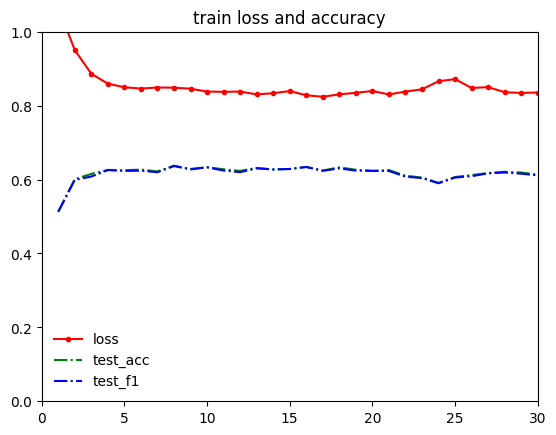

In [22]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [23]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/2layerba.xlsx')

In [24]:
torch.save(basenet.state_dict(), file_path + 'output/2layerba_state_dict.pth')

## 3层 FAM , 30 epochs

In [22]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 16,956,461 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in net.named_parameters()
    if name != "token_embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.token_embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, segments, valid_len), y = data
        tokens, segments, valid_len = [v.to(device) for v in (tokens, segments, valid_len)]
        y = y.to(device)
        l = loss(net(tokens, segments, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 1, loss 1.054, train_acc 0.547, train_f1 0.540, test_acc 0.556, test_f1 0.550, taking 382 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 2, loss 0.899, train_acc 0.628, train_f1 0.627, test_acc 0.630, test_f1 0.629, taking 381 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 3, loss 0.826, train_acc 0.624, train_f1 0.622, test_acc 0.625, test_f1 0.621, taking 381 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 4, loss 0.789, train_acc 0.675, train_f1 0.673, test_acc 0.674, test_f1 0.672, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 5, loss 0.759, train_acc 0.681, train_f1 0.680, test_acc 0.675, test_f1 0.674, taking 382 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 6, loss 0.732, train_acc 0.705, train_f1 0.704, test_acc 0.698, test_f1 0.696, taking 381 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 7, loss 0.709, train_acc 0.721, train_f1 0.719, test_acc 0.716, test_f1 0.714, taking 381 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 8, loss 0.687, train_acc 0.728, train_f1 0.728, test_acc 0.722, test_f1 0.721, taking 382 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 9, loss 0.666, train_acc 0.736, train_f1 0.734, test_acc 0.730, test_f1 0.728, taking 381 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 10, loss 0.640, train_acc 0.755, train_f1 0.753, test_acc 0.745, test_f1 0.743, taking 381 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 11, loss 0.618, train_acc 0.750, train_f1 0.747, test_acc 0.745, test_f1 0.742, taking 381 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 12, loss 0.599, train_acc 0.777, train_f1 0.776, test_acc 0.766, test_f1 0.764, taking 382 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 13, loss 0.576, train_acc 0.787, train_f1 0.786, test_acc 0.778, test_f1 0.777, taking 381 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.88it/s]


epoch 14, loss 0.559, train_acc 0.792, train_f1 0.793, test_acc 0.780, test_f1 0.780, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.88it/s]


epoch 15, loss 0.544, train_acc 0.796, train_f1 0.795, test_acc 0.782, test_f1 0.781, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 16, loss 0.532, train_acc 0.805, train_f1 0.803, test_acc 0.790, test_f1 0.788, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 17, loss 0.520, train_acc 0.814, train_f1 0.815, test_acc 0.794, test_f1 0.794, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 18, loss 0.510, train_acc 0.814, train_f1 0.814, test_acc 0.795, test_f1 0.795, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 19, loss 0.500, train_acc 0.818, train_f1 0.819, test_acc 0.793, test_f1 0.793, taking 382 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 20, loss 0.491, train_acc 0.820, train_f1 0.818, test_acc 0.796, test_f1 0.793, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.88it/s]


epoch 21, loss 0.482, train_acc 0.827, train_f1 0.828, test_acc 0.804, test_f1 0.804, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 22, loss 0.474, train_acc 0.827, train_f1 0.825, test_acc 0.801, test_f1 0.798, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.88it/s]


epoch 23, loss 0.466, train_acc 0.835, train_f1 0.834, test_acc 0.805, test_f1 0.803, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 24, loss 0.458, train_acc 0.838, train_f1 0.838, test_acc 0.807, test_f1 0.806, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 25, loss 0.452, train_acc 0.840, train_f1 0.840, test_acc 0.807, test_f1 0.807, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.88it/s]


epoch 26, loss 0.445, train_acc 0.845, train_f1 0.844, test_acc 0.812, test_f1 0.811, taking 382 seconds


100%|██████████| 1073/1073 [04:35<00:00,  3.89it/s]


epoch 27, loss 0.439, train_acc 0.850, train_f1 0.849, test_acc 0.812, test_f1 0.811, taking 381 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 28, loss 0.432, train_acc 0.850, train_f1 0.850, test_acc 0.807, test_f1 0.808, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 29, loss 0.426, train_acc 0.854, train_f1 0.853, test_acc 0.811, test_f1 0.810, taking 382 seconds


100%|██████████| 1073/1073 [04:36<00:00,  3.89it/s]


epoch 30, loss 0.420, train_acc 0.858, train_f1 0.858, test_acc 0.816, test_f1 0.815, taking 382 seconds
Training is finished.
训练损失:0.420, 训练集准确率:0.858, 训练集f1:0.858, 测试集准确率:0.816, 测试集f1:0.858, 在设备cuda:0上训练30周期, 耗时11451 s


## 保存结果

In [23]:
print(f"训练集最佳准确率: {max(train_accuracy):.3f},\n"
    f"训练集最佳F1分数: {max(train_f1):.3f},\n"
    f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

训练集最佳准确率: 0.858,
训练集最佳F1分数: 0.858,
测试集最佳准确率: 0.816,
测试集最佳F1分数: 0.815


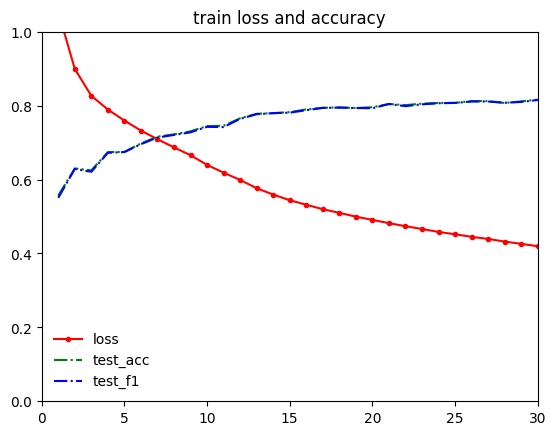

In [24]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [25]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/3layerfa.xlsx')

In [26]:
torch.save(net.state_dict(), file_path + 'output/3layer_state_dict.pth')

## 3 层 Baseline, 30 epochs

In [21]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 19,013,123 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in basenet.named_parameters()
    if name != "token_embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': basenet.token_embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
basenet.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    basenet.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, segments, valid_len), y = data
        tokens, segments, valid_len = [v.to(device) for v in (tokens, segments, valid_len)]
        y = y.to(device)
        l = loss(basenet(tokens, segments, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(basenet, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(basenet, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 1073/1073 [03:06<00:00,  5.74it/s]


epoch 1, loss 1.073, train_acc 0.506, train_f1 0.507, test_acc 0.519, test_f1 0.521, taking 252 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 2, loss 0.942, train_acc 0.598, train_f1 0.597, test_acc 0.604, test_f1 0.604, taking 254 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 3, loss 0.885, train_acc 0.596, train_f1 0.595, test_acc 0.599, test_f1 0.599, taking 254 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 4, loss 0.868, train_acc 0.607, train_f1 0.603, test_acc 0.611, test_f1 0.606, taking 254 seconds


100%|██████████| 1073/1073 [03:09<00:00,  5.68it/s]


epoch 5, loss 0.854, train_acc 0.606, train_f1 0.603, test_acc 0.608, test_f1 0.605, taking 254 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 6, loss 0.861, train_acc 0.615, train_f1 0.614, test_acc 0.615, test_f1 0.614, taking 254 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 7, loss 0.861, train_acc 0.630, train_f1 0.630, test_acc 0.624, test_f1 0.624, taking 254 seconds


 79%|███████▊  | 844/1073 [02:28<00:39,  5.76it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 17, loss 0.821, train_acc 0.641, train_f1 0.639, test_acc 0.633, test_f1 0.631, taking 254 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 18, loss 0.816, train_acc 0.643, train_f1 0.643, test_acc 0.633, test_f1 0.632, taking 254 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 19, loss 0.815, train_acc 0.639, train_f1 0.635, test_acc 0.636, test_f1 0.631, taking 254 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 20, loss 0.811, train_acc 0.642, train_f1 0.640, test_acc 0.637, test_f1 0.635, taking 254 seconds


100%|██████████| 1073/1073 [03:09<00:00,  5.68it/s]


epoch 21, loss 0.816, train_acc 0.637, train_f1 0.637, test_acc 0.635, test_f1 0.634, taking 255 seconds


100%|██████████| 1073/1073 [03:09<00:00,  5.67it/s]


epoch 22, loss 0.818, train_acc 0.641, train_f1 0.639, test_acc 0.634, test_f1 0.631, taking 255 seconds


100%|██████████| 1073/1073 [03:09<00:00,  5.68it/s]


epoch 23, loss 0.811, train_acc 0.640, train_f1 0.637, test_acc 0.633, test_f1 0.629, taking 255 seconds


100%|██████████| 1073/1073 [03:09<00:00,  5.67it/s]


epoch 24, loss 0.810, train_acc 0.634, train_f1 0.630, test_acc 0.624, test_f1 0.619, taking 255 seconds


100%|██████████| 1073/1073 [03:09<00:00,  5.67it/s]


epoch 25, loss 0.813, train_acc 0.644, train_f1 0.643, test_acc 0.640, test_f1 0.639, taking 255 seconds


  4%|▍         | 47/1073 [00:08<02:58,  5.74it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 1073/1073 [03:09<00:00,  5.68it/s]


epoch 29, loss 0.809, train_acc 0.639, train_f1 0.637, test_acc 0.632, test_f1 0.629, taking 254 seconds


100%|██████████| 1073/1073 [03:08<00:00,  5.68it/s]


epoch 30, loss 0.806, train_acc 0.648, train_f1 0.648, test_acc 0.636, test_f1 0.636, taking 254 seconds
Training is finished.
训练损失:0.806, 训练集准确率:0.648, 训练集f1:0.648, 测试集准确率:0.636, 测试集f1:0.636, 在设备cuda:0上训练30周期, 耗时7630 s


## 保存结果

In [22]:
print(f"训练集最佳准确率: {max(train_accuracy):.3f},\n"
    f"训练集最佳F1分数: {max(train_f1):.3f},\n"
    f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

训练集最佳准确率: 0.648,
训练集最佳F1分数: 0.648,
测试集最佳准确率: 0.640,
测试集最佳F1分数: 0.639


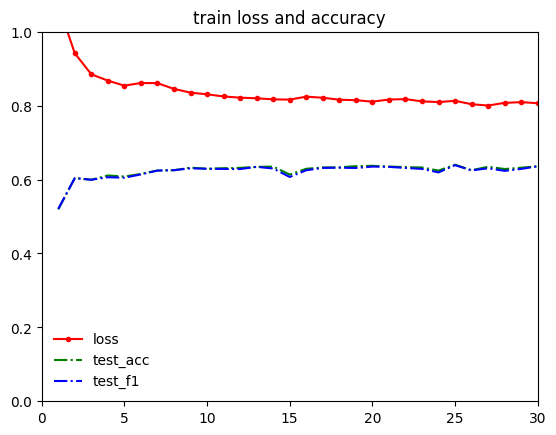

In [23]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [24]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/3layerba.xlsx')

In [25]:
torch.save(basenet.state_dict(), file_path + 'output/3layerba_state_dict.pth')

# 结尾